
Evaluating Ordinal Encoding:
Ridge (Ordinal) - RMSE: 30.2764, AUC: 0.9900
Confusion Matrix:
[[9 1]
 [1 9]]
Lasso (Ordinal) - RMSE: 34.5351, AUC: 1.0000
Confusion Matrix:
[[10  0]
 [ 0 10]]
Decision Tree (Ordinal) - RMSE: 56.4575, AUC: 0.8250
Confusion Matrix:
[[7 3]
 [3 7]]
Splines (Ordinal) - RMSE: 52.3749, AUC: 0.8900
Confusion Matrix:
[[8 2]
 [2 8]]
Best model for Ordinal Encoding: Ridge with RMSE: 30.2764



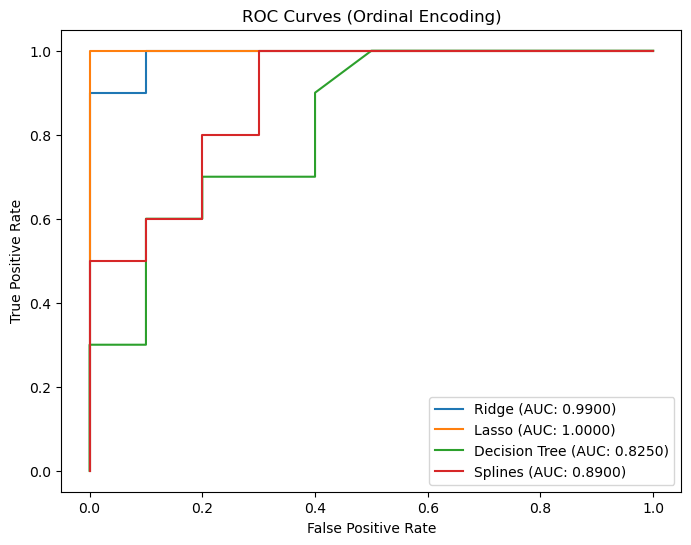

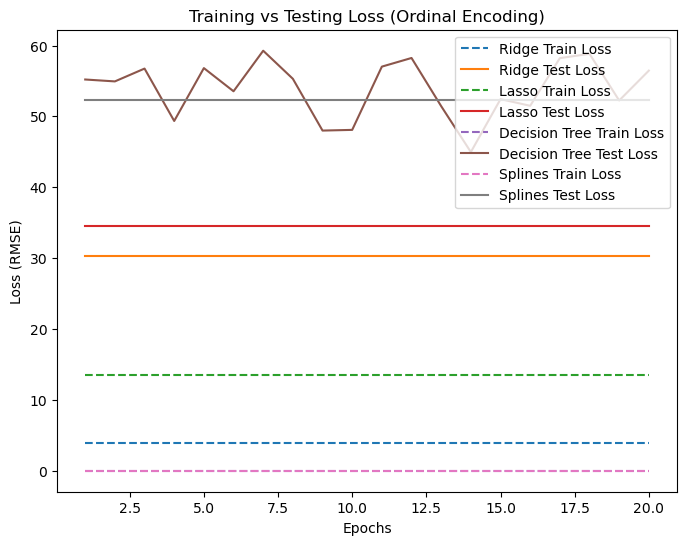


Evaluating One-Hot Encoding:
Ridge (One-Hot) - RMSE: 37.5690, AUC: 0.9800
Confusion Matrix:
[[9 1]
 [1 9]]
Lasso (One-Hot) - RMSE: 35.6655, AUC: 1.0000
Confusion Matrix:
[[10  0]
 [ 0 10]]
Decision Tree (One-Hot) - RMSE: 53.8986, AUC: 0.9000
Confusion Matrix:
[[8 2]
 [2 8]]
Splines (One-Hot) - RMSE: 50.5812, AUC: 0.9000
Confusion Matrix:
[[8 2]
 [2 8]]
Best model for One-Hot Encoding: Lasso with RMSE: 35.6655



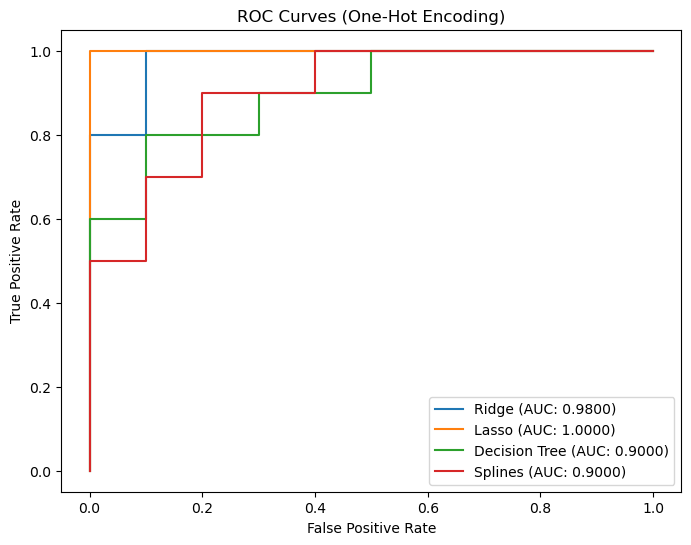

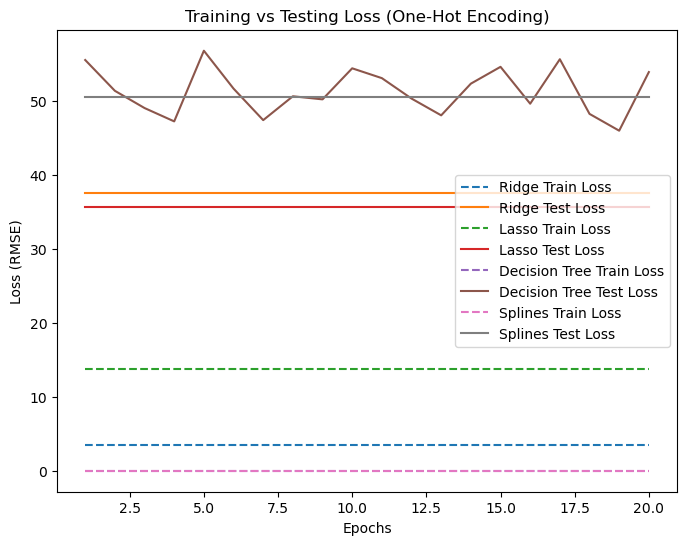

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, SplineTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, roc_curve

# Load the datasets
data = pd.read_csv(r"C:\Users\snehi\Documents\CDA_Assignments\case1Data.csv")
xnew = pd.read_csv(r"C:\Users\snehi\Documents\CDA_Assignments\case1Data_Xnew.csv")

# Identify categorical and numerical columns
categorical_cols = ['C_01', 'C_02', 'C_03', 'C_04', 'C_05']
numerical_cols = [col for col in data.columns if col not in categorical_cols + ['y']]

# Handle missing values for numerical data
num_imputer = SimpleImputer(strategy='mean')
data[numerical_cols] = num_imputer.fit_transform(data[numerical_cols])
xnew[numerical_cols] = num_imputer.transform(xnew[numerical_cols])

# Treat missing categorical values as a new category "Missing"
data[categorical_cols] = data[categorical_cols].astype(str).fillna("Missing")
xnew[categorical_cols] = xnew[categorical_cols].astype(str).fillna("Missing")

# Encoding
ordinal_encoder = OrdinalEncoder()
data_ordinal = data.copy()
data_ordinal[categorical_cols] = ordinal_encoder.fit_transform(data_ordinal[categorical_cols])
xnew_ordinal = xnew.copy()
xnew_ordinal[categorical_cols] = ordinal_encoder.transform(xnew_ordinal[categorical_cols])

encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
data_onehot = data.copy()
xnew_onehot = xnew.copy()
data_onehot_encoded = encoder.fit_transform(data_onehot[categorical_cols])
xnew_onehot_encoded = encoder.transform(xnew_onehot[categorical_cols])
data_onehot = data_onehot.drop(columns=categorical_cols).reset_index(drop=True)
xnew_onehot = xnew_onehot.drop(columns=categorical_cols).reset_index(drop=True)
data_onehot = pd.concat([data_onehot, pd.DataFrame(data_onehot_encoded, columns=encoder.get_feature_names_out(categorical_cols))], axis=1)
xnew_onehot = pd.concat([xnew_onehot, pd.DataFrame(xnew_onehot_encoded, columns=encoder.get_feature_names_out(categorical_cols))], axis=1)

# Standardize numerical features
scaler = StandardScaler()
data_ordinal[numerical_cols] = scaler.fit_transform(data_ordinal[numerical_cols])
data_onehot[numerical_cols] = scaler.transform(data_onehot[numerical_cols])
xnew_ordinal[numerical_cols] = scaler.transform(xnew_ordinal[numerical_cols])
xnew_onehot[numerical_cols] = scaler.transform(xnew_onehot[numerical_cols])

# Split data
X_ord, X_test_ord, y_ord, y_test_ord = train_test_split(data_ordinal.drop(columns=['y']), data_ordinal['y'], test_size=0.2, random_state=42)
X_oh, X_test_oh, y_oh, y_test_oh = train_test_split(data_onehot.drop(columns=['y']), data_onehot['y'], test_size=0.2, random_state=42)

# Models
models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Splines": make_pipeline(SplineTransformer(n_knots=5, degree=3), LinearRegression())
}

def evaluate_models(X_train, X_test, y_train, y_test, encoding_type):
    results = {}
    loss_plot_data = {}
    roc_data = {}
    print(f"\nEvaluating {encoding_type} Encoding:")
    
    for name, model in models.items():
        train_losses = []
        test_losses = []
        
        for epoch in range(1, 21):
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            train_loss = np.sqrt(mean_squared_error(y_train, y_train_pred))
            test_loss = np.sqrt(mean_squared_error(y_test, y_test_pred))
            train_losses.append(train_loss)
            test_losses.append(test_loss)
        
        loss_plot_data[name] = (train_losses, test_losses)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        auc = roc_auc_score((y_test > np.median(y_test)).astype(int), y_pred)
        fpr, tpr, _ = roc_curve((y_test > np.median(y_test)).astype(int), y_pred)
        roc_data[name] = (fpr, tpr, auc)
        
        cm = confusion_matrix((y_test > np.median(y_test)).astype(int), (y_pred > np.median(y_pred)).astype(int))
        print(f"{name} ({encoding_type}) - RMSE: {rmse:.4f}, AUC: {auc:.4f}")
        print("Confusion Matrix:")
        print(cm)
        results[name] = rmse
    
    best_model = min(results, key=results.get)
    print(f"Best model for {encoding_type} Encoding: {best_model} with RMSE: {results[best_model]:.4f}\n")
    
    plt.figure(figsize=(8, 6))
    for name, (fpr, tpr, auc) in roc_data.items():
        plt.plot(fpr, tpr, label=f'{name} (AUC: {auc:.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves ({encoding_type} Encoding)')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(8, 6))
    for name, (train_losses, test_losses) in loss_plot_data.items():
        plt.plot(range(1, 21), train_losses, linestyle='dashed', label=f'{name} Train Loss')
        plt.plot(range(1, 21), test_losses, label=f'{name} Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (RMSE)')
    plt.title(f'Training vs Testing Loss ({encoding_type} Encoding)')
    plt.legend()
    plt.show()
    
    return results, best_model

# Evaluate models
results_ordinal, best_model_ord = evaluate_models(X_ord, X_test_ord, y_ord, y_test_ord, "Ordinal")
results_onehot, best_model_oh = evaluate_models(X_oh, X_test_oh, y_oh, y_test_oh, "One-Hot")

# Save results
np.savetxt("predictions_YourStudentNos.csv", ynew_pred, delimiter=",")
np.savetxt("estimatedRMSE_YourStudentNos.csv", [rmse_estimate], delimiter=",")